# Qcodes example with HP8753D

This is the example notebook illustrating how to use the QCoDeS driver
for the HP 8753D Network Analyzer.

Throughout the notebook, we assume that a Mini-Circuits SLP-550+ Low Pass
filter is connected as the DUT.

In [1]:
# allow in-notebook matplotlib plots
%matplotlib notebook

# import QCoDeS

import qcodes as qc
from qcodes.instrument_drivers.HP.HP8753D import HP8753D

# we'll need this later
from functools import partial

# import logging
# logging.basicConfig(level=logging.DEBUG)

In [2]:
# Instantiate the instrument
vna = HP8753D('vna', 'GPIB0::6::INSTR')

Connected to: HEWLETT PACKARD 8753D (serial:0, firmware:6.14) in 0.23s


In [3]:
# for the sake of this tutorial, we reset the instrument
vna.reset()

# The following functions gives a nice self-explanatory
# overview of the available instrument settings

vna.print_readable_snapshot(update=True)

vna:
	parameter         value
--------------------------------------------------------------------------------
IDN                :	{'vendor': 'HEWLETT PACKARD', 'model': '8753D', 'serial'...
averaging          :	OFF 
display_format     :	Log mag 
display_reference  :	0 (dim. less)
display_scale      :	10 (dim. less)
number_of_averages :	16 
output_power       :	0 (dBm)
s_parameter        :	S11 
start_freq         :	30000 (Hz)
stop_freq          :	6e+09 (Hz)
sweep_time         :	0.175 (s)
timeout            :	10 (s)
trace              :	Not available 
trace_points       :	201 


## Single trace measurement

In [5]:
# Let's get a single trace of S21 with 10 averages
# with a frequency range from 100 kHz to 1 GHz
# on a linear scale
vna.display_format('Lin mag')
vna.s_parameter('S21')
vna.start_freq(100e3)
vna.stop_freq(1e9)

# and let's adjust the y-scale to fit
vna.display_scale(0.12)
vna.display_reference(-0.1)

# and finally enable averaging
vna.averaging('ON')
vna.number_of_averages(10)

DataSet:
   location = 'data/2017-11-02/#011_{name}_14-33-04'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | vna_trace  | trace        | (201,)
acquired at 2017-11-02 14:33:04


<IPython.core.display.Javascript object>


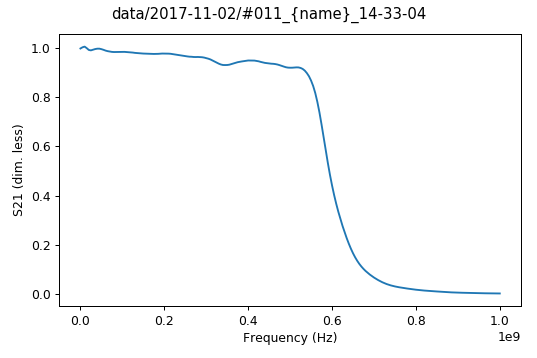

In [6]:
# Now aquire a trace
vna.trace.prepare_trace()  # this must be called prior to a Measurement or Loop
tracedata = qc.Measure(vna.trace).run()  # this returns a dataset
plot = qc.MatPlot(tracedata.arrays['vna_trace'])

## Acquiring traces while sweeping

In [7]:
# Now we'll vary the output power and acquire a trace for each power
# to examine how more power reduces the measurement noise

# We have to ensure that the VNA finishes averaging before moving
# to the next power

n_avgs = 10
vna.number_of_averages(n_avgs)
# make a Task that runs N sweeps and waits for them to finish
run_sweeper = qc.Task(partial(vna.run_N_times, n_avgs))


# prepare the trace
vna.trace.prepare_trace()

# set up a Loop
loop = qc.Loop(vna.output_power.sweep(-84, -40, num=20)).each(run_sweeper, vna.trace)
data = loop.get_data_set(name='HP8753D_tutorial')

# set up plotting
plot = qc.QtPlot()  # create a plot
plot.add(data.vna_trace)  # add a graph to the plot
# run the loop
_ = loop.with_bg_task(plot.update, plot.save).run() 

Started at 2017-11-02 14:33:27
DataSet:
   location = 'data/2017-11-02/#012_HP8753D_tutorial_14-33-15'
   <Type>   | <array_id>           | <array.name> | <array.shape>
   Setpoint | vna_output_power_set | output_power | (20,)
   Measured | vna_trace            | trace        | (20, 201)
Finished at 2017-11-02 14:34:40


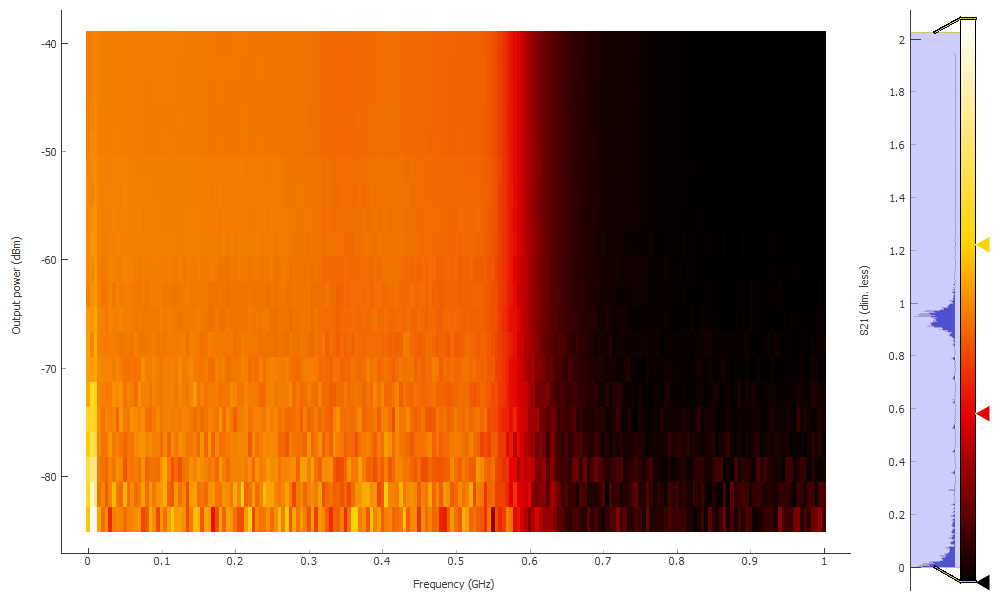

In [8]:
# The resulting plot is indeed pretty
plot